In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister
# from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from libs_qrem import tensored_meas_cal, TensoredMeasFitter
from osp_solutions.ignis_expval import expectation_value
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis

In [4]:
# Import mitiq for zne
# unused for this file
# import mitiq

In [5]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
# from qiskit.ignis_tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
from osp_solutions.circuits import trotter_gate, trotterize, make_initial_state, general_subspace_encoder, general_subspace_decoder 

In [7]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")

In [ ]:
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
print("trotter step list: ", num_steps_list)

scale_factors = [1.0, 2.0, 3.0] # unused for this file

shots = 1 << 13
reps = 8 # unused

Zero = np.array([[1,0],
                 [0,0]])
One = np.array([[0,0],
                [0,1]])
target_state = np.kron(Zero, np.kron(One, One)) ###! big endian
# target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

trotter step list:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [9]:
# QREM
qr = QuantumRegister(num_qubits, name="calq")
meas_calibs, state_labels = tensored_meas_cal(qr=qr, circlabel='mcal')
# we have to feed initial_layout to calibration matrix
cal_results = backend.run(meas_calibs,
                          shots=shots,
                          # optimization_level=3, 
                          # initial_layout = initial_layout,
                         ).result()
# print('Job ID', cal_job.job_id())

# retrieved_cal_job = cal_job
# cal_results = retrieved_cal_job.result()
meas_fitter = TensoredMeasFitter(cal_results, state_labels, circlabel='mcal')

from libs_qrem import LeastNormFilter
meas_filter = LeastNormFilter(num_qubits, meas_fitter.cal_matrices)

In [ ]:
qrem_fid_list = []
qrem_stddev_list = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, name="q")
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    general_subspace_encoder(qc, targets=[0, 1, 2]) # encode
    trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
    general_subspace_decoder(qc, targets=[0, 1, 2]) # decode

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    #! if num_steps > 1:
    qc = qc.assign_parameters({dt: target_time / num_steps})
    #! print(qc)
    print("created qc")

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = StateTomography(qc).circuits()  #! state tomography requires === BIG ENDIAN === 
    st_qcs = rename_qcs_StateTomography_to_ignis(st_qcs)
    # from osp_solutions.tomography import state_tomography_circuits
    from osp_solutions.tomography import StateTomographyFitter
    # st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
    print("created st_qcs (length:", len(st_qcs), ")")

    # remove barriers
    st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
    print("removed barriers from st_qcs")

    # optimize circuit
    t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

    # zne wrapping
    zne_qcs = t3_st_qcs
    # zne_qcs = zne_wrapper(t3_st_qcs, scale_factors = scale_factors, pt = False)
    # print("created zne_qcs (length:", len(zne_qcs), ")")

    # optimization_level must be 0
    # feed initial_layout here to see the picture of the circuits before casting the job
    t3_zne_qcs = transpile(zne_qcs, 
                           optimization_level=0, 
                           basis_gates=["sx", "cx", "rz"], 
                           initial_layout=initial_layout)
    print("created t3_zne_qcs (length:", len(t3_zne_qcs), ")")
    
    ### execute circuits, 8 iterations
    qrem_fids = []
    for _ in range(reps):
        raw_results = backend.run(t3_zne_qcs, 
                                  # backend, 
                                  shots=shots, 
                                  optimization_level=0,
                                 ).result()
        mit_results = meas_filter.apply(raw_results) ### QREM
        qrem_rho = StateTomographyFitter(raw_results, t3_zne_qcs).fit(method='lstsq')
        qrem_fids.append(state_fidelity(qrem_rho, target_state))

    qrem_fid_list.append(np.mean(qrem_fids))
    qrem_stddev_list.append(np.std(qrem_fids))
    
    t2 = time.perf_counter()
    print('qrem state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(qrem_fids), np.std(qrem_fids)))
    print("time:", t2 - t1)
    print()

trotter steps:  1
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
qrem state tomography fidelity = 0.9006 ± 0.0012
time: 1.6247029170626774

trotter steps:  2
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
qrem state tomography fidelity = 0.9006 ± 0.0010
time: 1.5503753341035917

trotter steps:  3
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
qrem state tomography fidelity = 0.0796 ± 0.0009
time: 1.6789659999776632

trotter steps:  4
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
qrem state tomography fidelity = 0.0166 ± 0.0003
time: 1.7088418749626726

trotter steps:  5
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
creat

In [12]:
with open("e0d0_qrem.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fid": qrem_fid_list, "stddev": qrem_stddev_list}, f)

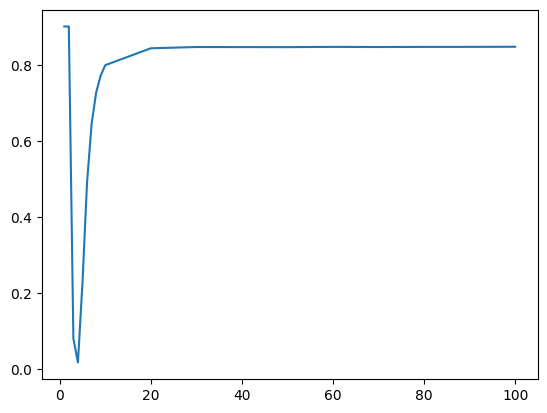

In [13]:
plt.plot(num_steps_list, qrem_fid_list)

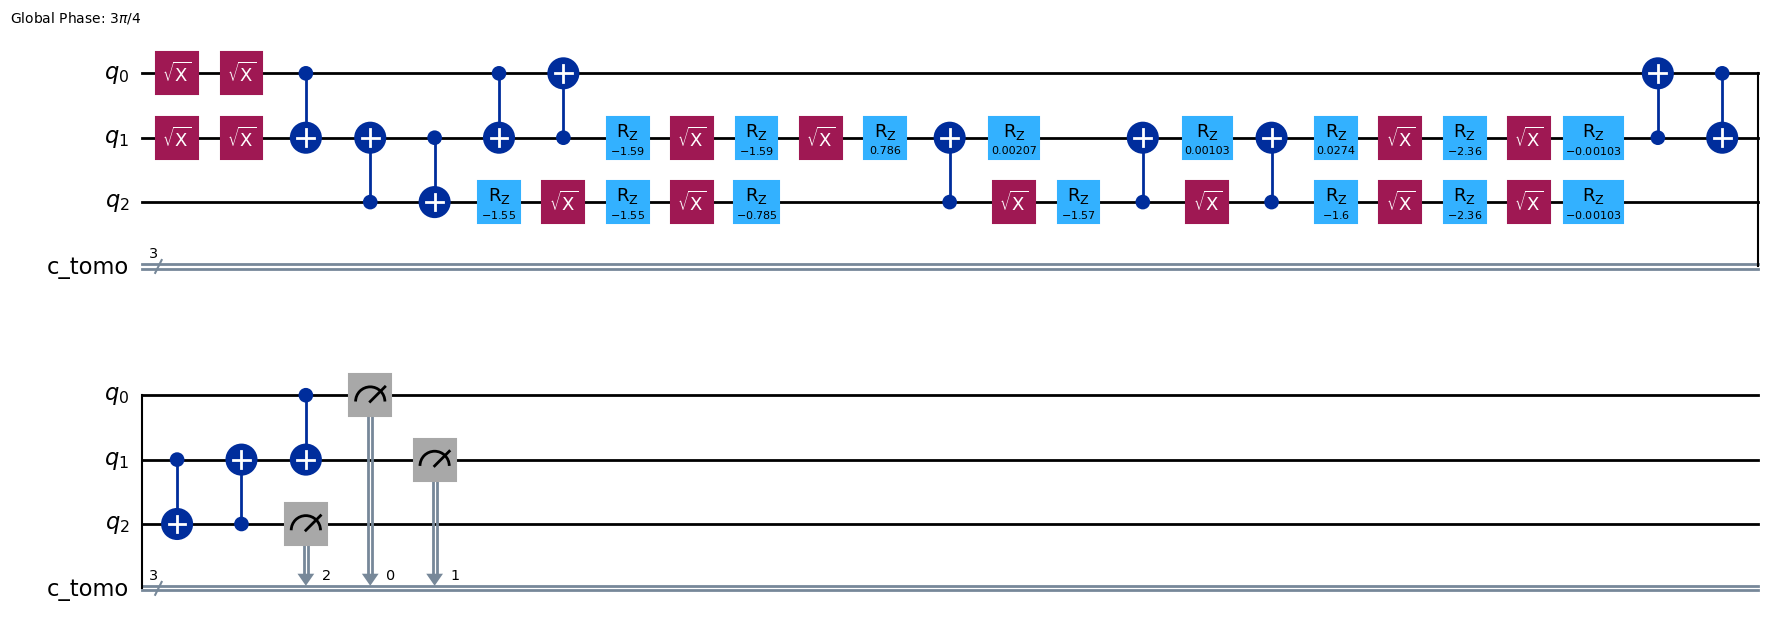

In [14]:
t3_st_qcs[0].draw("mpl")

In [18]:
print(backend)

AerSimulator('aer_simulator_from(fake_jakarta)'
             noise_model=<NoiseModel on ['reset', 'x', 'id', 'sx', 'measure', 'cx']>)
